# Population Data from CSV

This notebooks reads sample population data from `data/atlantis.csv` and plots it using Matplotlib. Edit `data/atlantis.csv` and re-run this cell to see how the plots change!

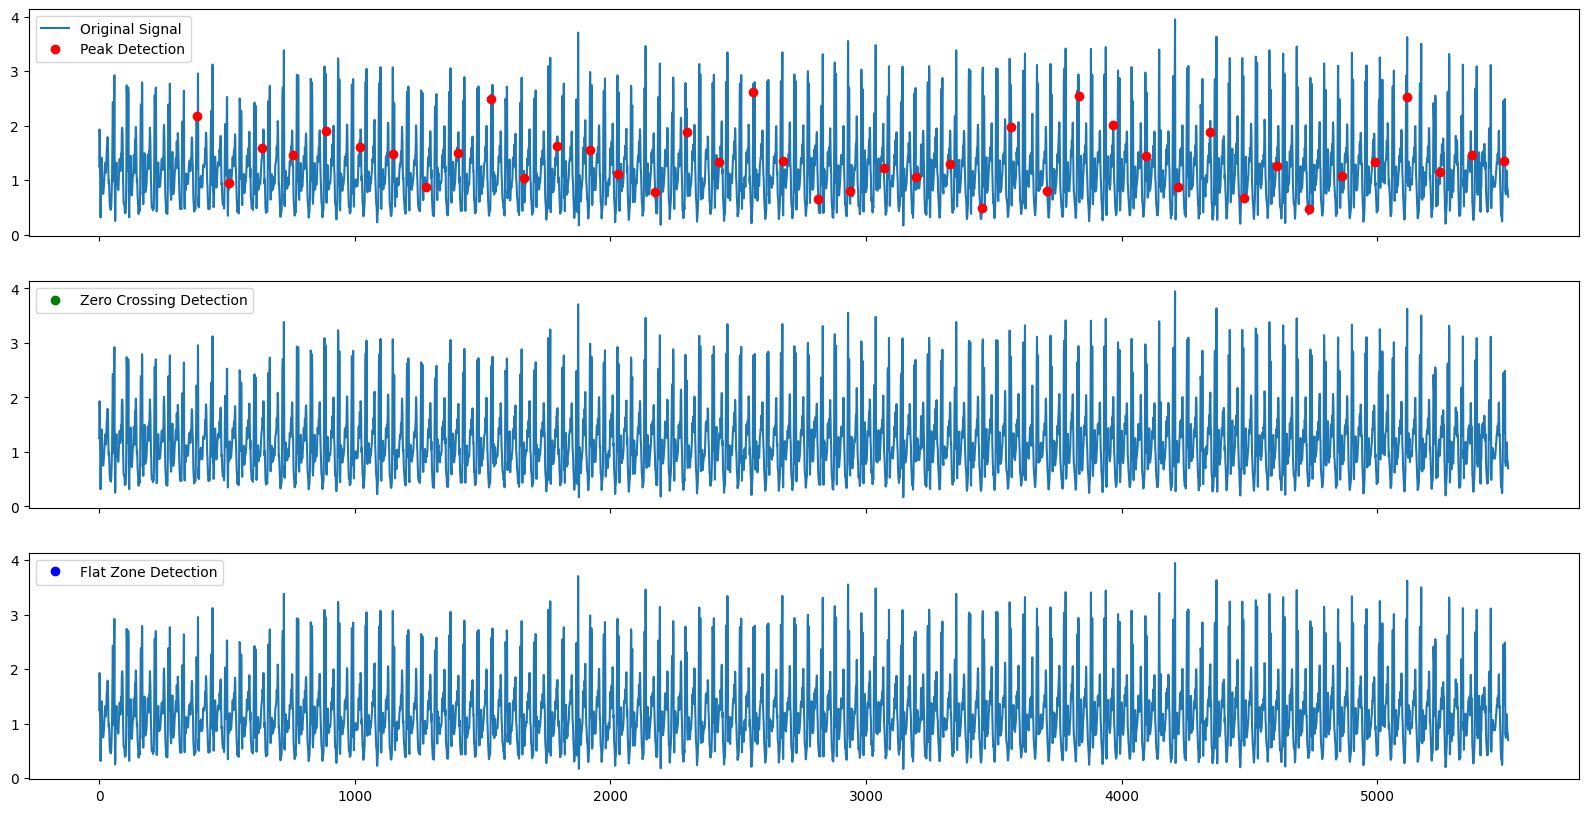

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# 获取数据
data = []
with open('/workspaces/codespaces-jupyter/data/wlk_7/sub_1.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # 跳过标题行
    for row in reader:
        data.append([float(row[1]), float(row[2]), float(row[3])])

# 窗口大小和与窗口重叠
window_size = 256
step_size = window_size // 2


# 定义步数检测函数
def detect_peaks(data):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            peaks.append(i)
    if peaks:
        return peaks[-1]
    else:
        return None


def detect_crossings(data):
    crossings = []
    for i in range(1, len(data)):
        if (data[i - 1] > 0 and data[i] < 0) or (data[i - 1] < 0 and data[i] > 0):
            crossings.append(i)
    if crossings:
        return crossings[-1]
    else:
        return None


def detect_flat_zones(data):
    k = 5
    l = 5
    epsilon = 0.05
    steps = []
    for n in range(k, len(data) - l):
        flat_low = all(abs(data[n - i]) <= epsilon for i in range(1, k + 1))
        flat_high = all(abs(data[j] - data[n]) <= epsilon for j in range(n, n + l))

        if flat_low and flat_high:
            steps.append(n)

    if steps:
        return steps[-1]
    else:
        return None


# 每个窗口中检测步数
peaks = []
crossings = []
flats = []
for i in range(step_size, len(data) - window_size + step_size, step_size):
    window_data = data[i - step_size:i + 1 + step_size]
    window_signal = np.sqrt(np.sum(np.square(window_data), axis=1))
    peak_points = detect_peaks(window_signal)
    crossing_points = detect_crossings(window_signal)
    flat_points = detect_flat_zones(window_signal)
    if peak_points is not None:
        peaks.append(peak_points + i)
    if crossing_points is not None:
        crossings.append(crossing_points + i)
    if flat_points is not None:
        flats.append(flat_points + i)

# 绘制折线图
t = range(len(data))

fig, axs = plt.subplots(3, sharex=True, sharey=False, figsize=(20, 10))

axs[0].plot(t, np.sqrt(np.sum(np.square(data), axis=1)), label='Original Signal')

valid_peaks = [idx for idx in peaks if idx < len(data)]
axs[0].plot(valid_peaks, np.sqrt(np.sum(np.square(np.array(data)[valid_peaks]), axis=1)),
            'o', color='red', label='Peak Detection')
axs[0].legend(loc='best')

valid_crossings = [idx for idx in crossings if idx < len(data)]
axs[1].plot(t, np.sqrt(np.sum(np.square(data), axis=1)))
axs[1].plot(valid_crossings, np.sqrt(np.sum(np.square(np.array(data)[valid_crossings]), axis=1)),
            'o', color='green', label='Zero Crossing Detection')
axs[1].legend(loc='best')

valid_flats = [idx for idx in flats if idx < len(data)]
axs[2].plot(t, np.sqrt(np.sum(np.square(data), axis=1)))
axs[2].plot(valid_flats, np.sqrt(np.sum(np.square(np.array(data)[valid_flats]), axis=1)),
            'o', color='blue', label='Flat Zone Detection')
axs[2].legend(loc='best')

plt.show()


步频: 9.336846163732169
步幅长度之和: 1518.0605988848222
步数: 1453
速度: 9.75491966896814
Stride length: 1.0447767370163952
时间: 155.62 s


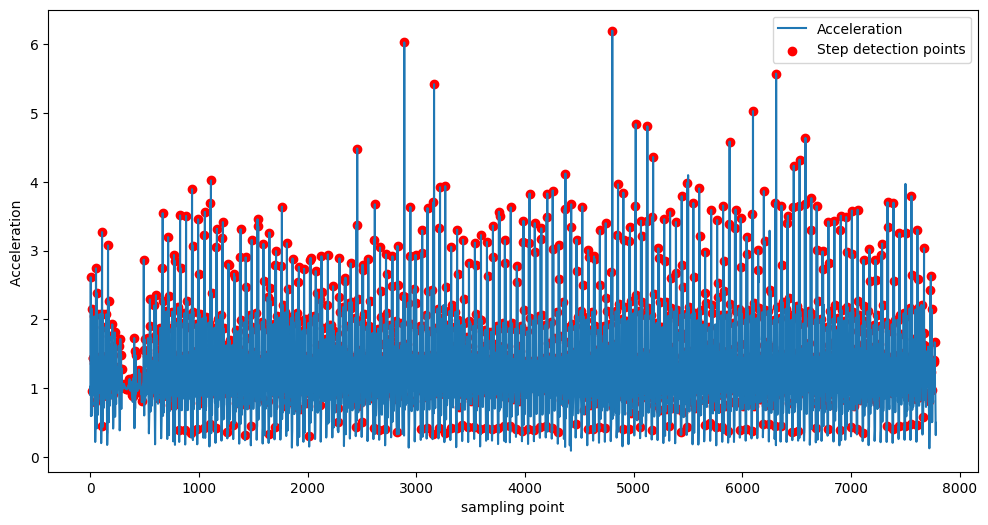

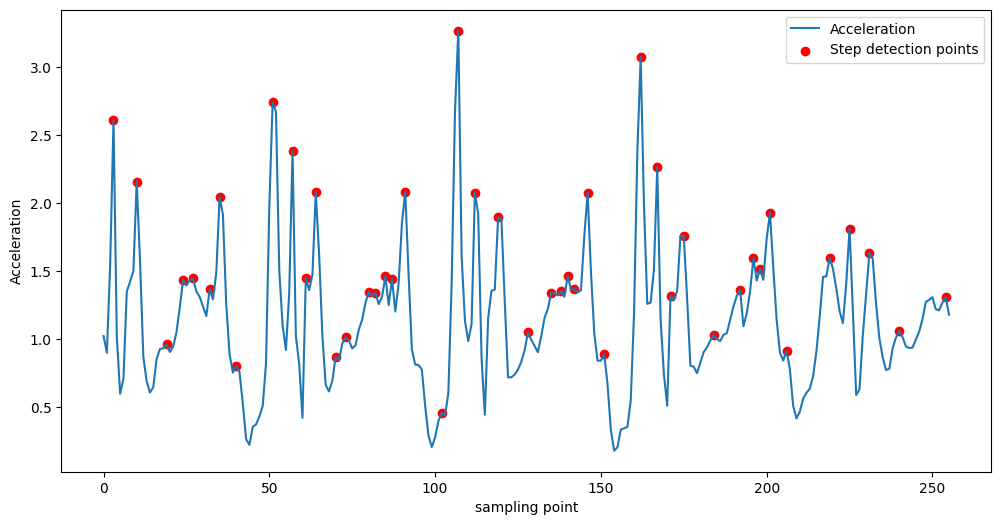

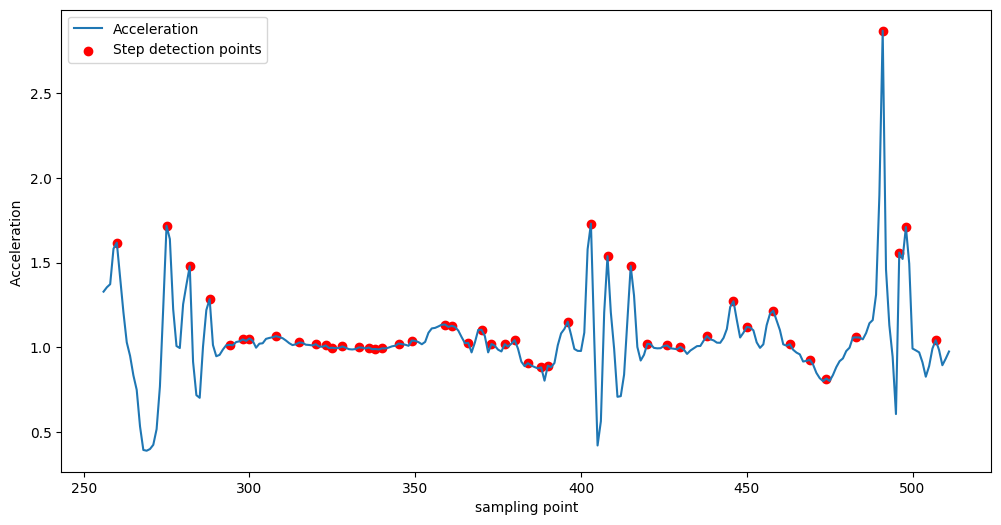

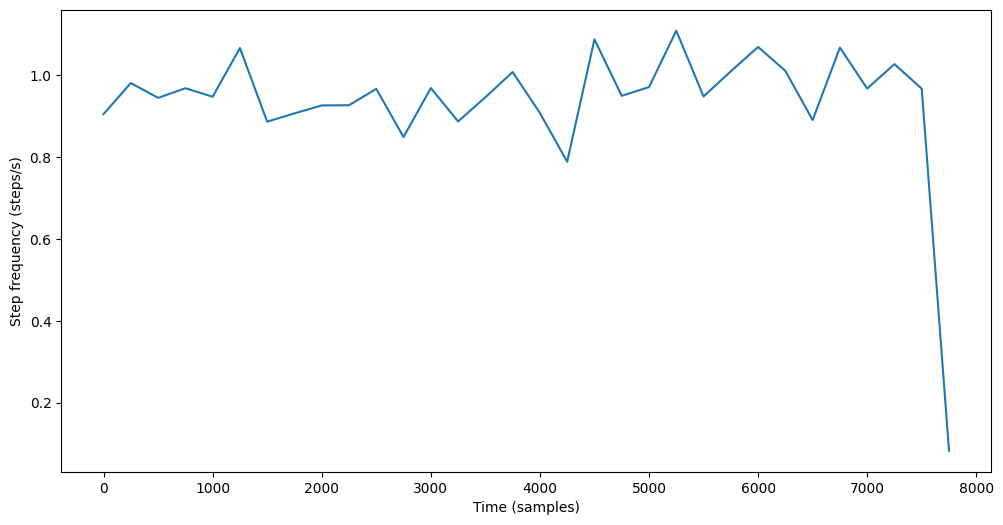

In [6]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv(r'/workspaces/codespaces-jupyter/data/wlk_7/sub_2.csv')

# 计算步数和步长
window_size_seconds = 5  # 窗口大小（秒）
sampling_frequency = 50  # 采样频率（Hz）
window_size_samples = int(window_size_seconds * sampling_frequency)  # 窗口大小（采样点数）
step_length_params = {
    'alpha': 0.1,  # 步幅参数 alpha
    'beta': 0.1,   # 步幅参数 beta
    'gamma': 0.1   # 步幅参数 gamma
}

step_count = 0
stride_lengths = []
step_indices = []
data['acceleration'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]
    acceleration = window['acceleration']  # 假设加速度数据列名为 'acceleration'

    # 检测步幅
    peaks = acceleration[(acceleration.shift(1) < acceleration) & (acceleration.shift(-1) < acceleration)]
    stride_count = len(peaks)
    step_indices.extend(peaks.index.tolist())

    # 计算步幅长度
    variance = acceleration.std()**2
    stride_length = step_length_params['alpha'] * stride_count + step_length_params['beta'] * variance + step_length_params['gamma']
    
    stride_lengths.append(stride_length)

    # 更新步数
    step_count += stride_count
variance = acceleration.std()**2
duration = len(data) / sampling_frequency # 数据持续时间（单位：小时）
step_frequency=(step_count)/duration
# 计算速度
stride_length1 = step_length_params['alpha'] *step_frequency + step_length_params['beta'] * variance + step_length_params['gamma']
total_stride_length = stride_length1*step_count  # 所有步幅长度之和（单位：公里）

speed = (total_stride_length) / duration # 速度（单位：km/h）

print("步频:", step_frequency)
print("步幅长度之和:", total_stride_length)
print("步数:", step_count)
print("速度:", speed)
print("Stride length:",stride_length1)
sampling_frequency = 50  # 将采样率传递给变量sampling_frequency
duration = len(data) / sampling_frequency  # 计算持续时间（单位：秒）
print("时间:",duration,  "s")
# 绘制信号图
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['acceleration'], label='Acceleration')
plt.scatter(step_indices, data['acceleration'][step_indices], color='red', label='Step detection points')
plt.xlabel('sampling point')
plt.ylabel('Acceleration ')
plt.legend()
plt.show()
# 绘制信号图
plt.figure(figsize=(12, 6))
start_index = 0
end_index = int(sampling_frequency * 5.12)  # calculate index up to 5.12 seconds
step_indices_np = np.array(step_indices)  # convert step_indices to numpy array
mask = (step_indices_np >= start_index) & (step_indices_np < end_index)
plt.plot(data.index[start_index:end_index], data['acceleration'][start_index:end_index], label='Acceleration')
plt.scatter(step_indices_np[mask], data['acceleration'].iloc[step_indices_np[mask]], color='red', label='Step detection points')
plt.xlabel('sampling point')
plt.ylabel('Acceleration')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
start_index = 256
end_index = int(sampling_frequency * 10.24)  # calculate index up to 5.12 seconds
step_indices_np = np.array(step_indices)  # convert step_indices to numpy array
mask = (step_indices_np >= start_index) & (step_indices_np < end_index)
plt.plot(data.index[start_index:end_index], data['acceleration'][start_index:end_index], label='Acceleration')
plt.scatter(step_indices_np[mask], data['acceleration'].iloc[step_indices_np[mask]], color='red', label='Step detection points')
plt.xlabel('sampling point')
plt.ylabel('Acceleration ')
plt.legend()
plt.show()
# 绘制步频折线图
step_frequencies = [stride_count / window_size_seconds for stride_count in stride_lengths]
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(data), window_size_samples), step_frequencies)
plt.xlabel('Time (samples)')
plt.ylabel('Step frequency (steps/s)')
plt.show()


步数： 424
步频： 4.2926730261822605 Hz
步长： 0.6342088366920241
时间： 98.54
速度： 2.728887221000794


Text(0, 0.5, 'Acceleration')

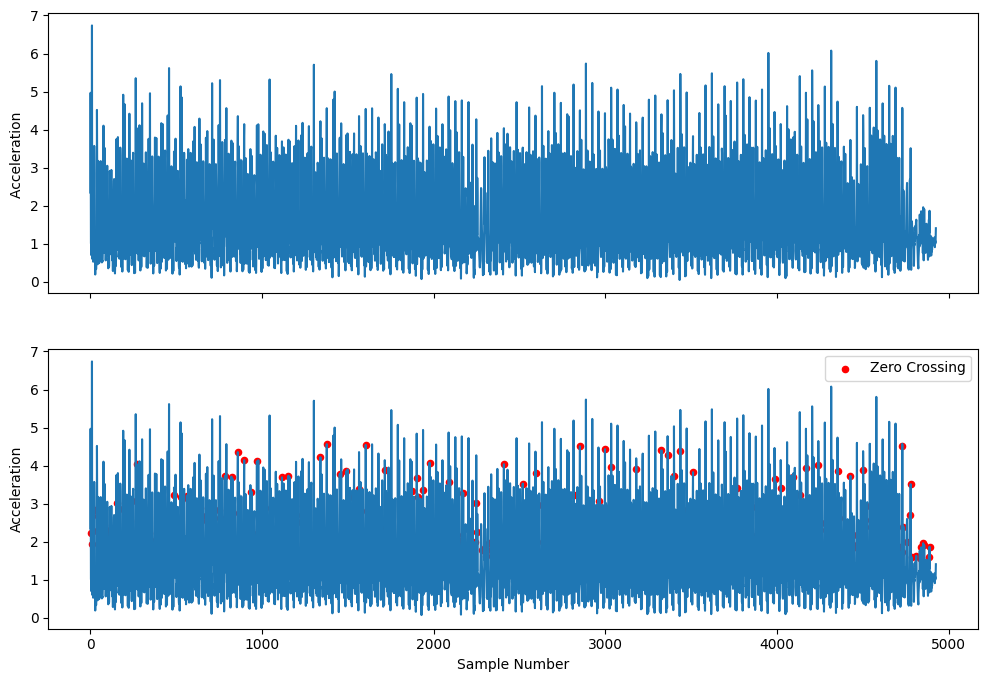

In [11]:
import csv
import matplotlib.pyplot as plt
import numpy as np
# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/jog_9/sub_1.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1]))
        y_axis.append(float(row[2]))
        z_axis.append(float(row[3]))

# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]

fs = 50

# Zero Crossing Detection的阈值和初始状态
threshold = sum(magnitudes) / len(magnitudes)
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True

# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)

# 计算每个步幅的距离
step_length_params = {
    'alpha': 0.3,  # 步幅参数 alpha
    'beta': 0.4,   # 步幅参数 beta
    'gamma': 0.3   # 步幅参数 gamma
}

time_seconds = len(magnitudes)/ fs

# 计算步频（步数/秒）
step_frequency = len(stride_lengths) / time_seconds

# 计算每个步幅的频率和方差

variances=np.var(magnitudes)

alpha = 0.1
beta =0.1
gamma =0.1

stride_length = alpha*step_frequency + beta*variances+ gamma
speed=(stride_length*num_steps)/time_seconds
print("步数：", num_steps)
print("步频：", step_frequency, "Hz")
print("步长：", stride_length)
print("时间：", time_seconds)
print("速度：", speed)


# 绘制加速度magnitude和Zero Crossing检测图
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
axs[0].plot(magnitudes)
axs[0].set_ylabel("Acceleration ")
axs[1].plot(magnitudes)
axs[1].scatter(crossing_points_x, crossing_points_y, s=20, c='r', marker='o', label='Zero Crossing')
axs[1].legend()
axs[1].set_xlabel("Sample Number")
axs[1].set_ylabel("Acceleration")

number of step: 646
step_frequency: 6.555713415871727
flat_area_stride_length: 0.8605128756609707
speed: 5.641275803500985


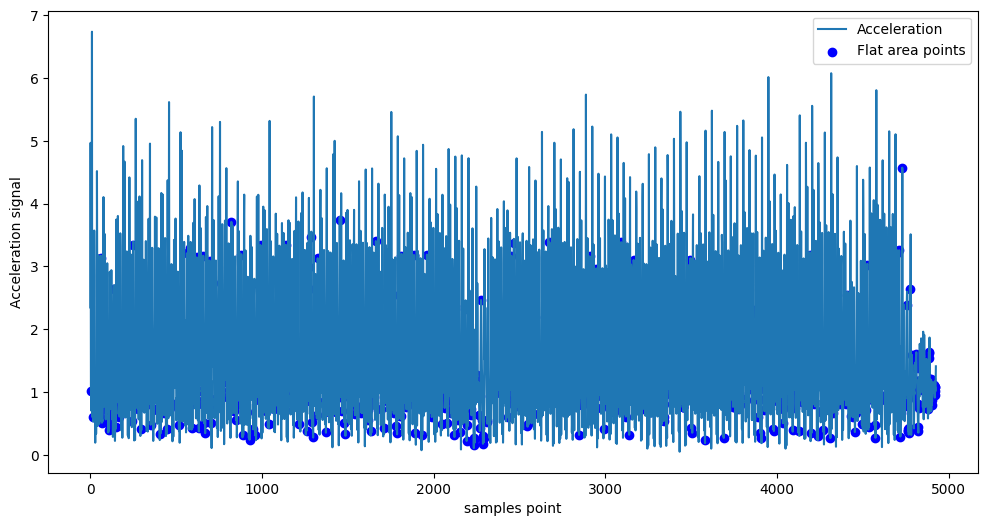

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



def flat_area_detection(signal, threshold):
    diff = np.abs(np.diff(signal))
    return np.where(diff <= threshold)[0]

# 读取CSV文件

data = pd.read_csv(r'/workspaces/codespaces-jupyter/data/jog_9/sub_1.csv')

# 计算步数和步长
window_size_seconds = 5  # 窗口大小（秒）
sampling_frequency = 50  # 采样频率（Hz）
window_size_samples = int(window_size_seconds * sampling_frequency)  # 窗口大小（采样点数）
step_length_params = {
    'alpha': 0.1,  # 步幅参数 alpha
    'beta': 0.1,   # 步幅参数 beta
    'gamma': 0.1   # 步幅参数 gamma
}

step_count = 0
stride_lengths = []
step_indices = []
one_crossing_indices = []
flat_area_indices = []
data['acceleration'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)


one_crossing_indices = []
flat_area_indices = []

one_crossing_step_count = 0
flat_area_step_count = 0
one_crossing_stride_lengths = []
flat_area_stride_lengths = []
one_crossing_steps = []
flat_area_steps = []

for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]
    acceleration = window['acceleration']  # 假设加速度数据列名为 'acceleration'

    # 计算方差
    variance = np.var(acceleration)


    
    

    # 平坦区域检测
    flat_areas = flat_area_detection(acceleration.values, threshold=0.1)
    flat_area_indices.extend(flat_areas + i)
    flat_area_step_count += len(flat_areas)
    flat_area_steps.append(len(flat_areas))
    


# 计算方差
variance = np.var(data['acceleration'])
sampling_frequency = 50  # 将采样率传递给变量sampling_frequency
duration = len(data) / sampling_frequency  # 计算持续时间（单位：秒）
step_frequency=flat_area_step_count/duration
flat_area_stride_length = step_length_params['alpha'] * step_frequency + step_length_params['beta'] * variance + step_length_params['gamma']
speed=(flat_area_stride_length*flat_area_step_count)/duration
print("number of step:",flat_area_step_count)
print("step_frequency:",step_frequency)
print("flat_area_stride_length:",flat_area_stride_length)
print("speed:",speed)


# 绘制信号图
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['acceleration'], label='Acceleration')
plt.scatter(flat_area_indices, data['acceleration'][flat_area_indices], color='blue', label='Flat area points')
plt.xlabel('samples point')
plt.ylabel('Acceleration signal')
plt.legend()
plt.show()
# 绘制one_crossing_stride_lengths、flat_area_stride_lengths和stride_lengths三个列表的折线图




步幅长度之和: 287.35757899473964
步数: 924
速度: 2.6061815617153967
1交叉总步数: 425.0
平坦区域总步数: 2346
1交叉步幅长度之和: 265.1394715669076
平坦区域步幅长度之和: 713.9394715669075
步幅长度: 0.3109930508601078
1交叉步幅长度: 0.3119287900787148
平坦区域步幅长度: 0.3043220253908387
时间: 110.26 s
1交叉区域速度: 2.4  m/s
平坦区域速度: 6.48  m/s


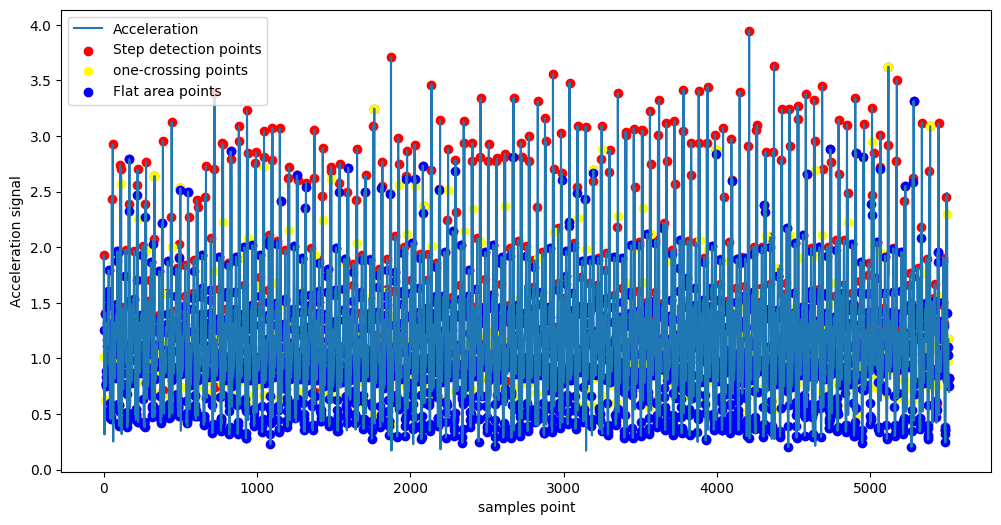

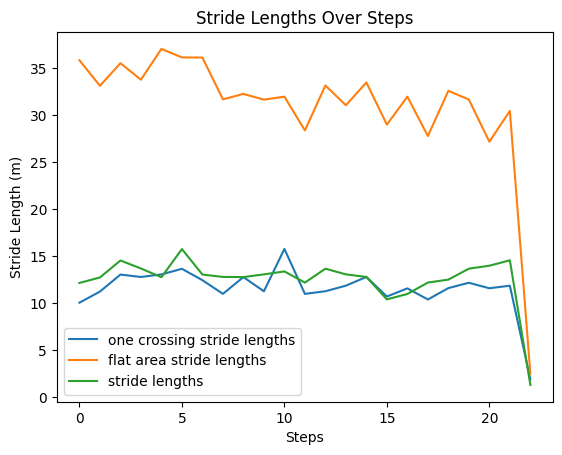

In [31]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def one_crossing_detection(signal, crossing_value=1):
    shifted_signal = signal - crossing_value
    return np.where(np.diff(np.sign(shifted_signal)))[0]

def flat_area_detection(signal, threshold):
    diff = np.abs(np.diff(signal))
    return np.where(diff <= threshold)[0]

# 读取CSV文件

data = pd.read_csv(r'/workspaces/codespaces-jupyter/data/wlk_7/sub_1.csv')

# 计算步数和步长
window_size_seconds = 5  # 窗口大小（秒）
sampling_frequency = 50  # 采样频率（Hz）
window_size_samples = int(window_size_seconds * sampling_frequency)  # 窗口大小（采样点数）
step_length_params = {
    'alpha': 0.3,  # 步幅参数 alpha
    'beta': 0.4,   # 步幅参数 beta
    'gamma': 0.3   # 步幅参数 gamma
}

step_count = 0
stride_lengths = []
step_indices = []
one_crossing_indices = []
flat_area_indices = []
data['acceleration'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]
    acceleration = window['acceleration']  # 假设加速度数据列名为 'acceleration'

    # 检测步幅
    peaks = acceleration[(acceleration.shift(1) < acceleration) & (acceleration.shift(-1) < acceleration)]
    stride_count = len(peaks)
    step_indices.extend(peaks.index.tolist())
    

    # 零交叉检测和平坦区域检测
    
    # 1交叉检测
    one_crossings = one_crossing_detection(acceleration.values, crossing_value=1)
    one_crossing_indices.extend(one_crossings + i)
    
    flat_areas = flat_area_detection(acceleration.values, threshold=0.1)
    flat_area_indices.extend(flat_areas + i)
    

    # 计算步幅长度
    variance = acceleration.std()**2
    stride_length = step_length_params['alpha'] * stride_count + step_length_params['beta'] * variance + step_length_params['gamma']
    
    stride_lengths.append(stride_length)

    # 更新步数
    step_count += stride_count

# 计算速度
total_stride_length = sum(stride_lengths)  # 所有步幅长度之和（单位：公里）
duration = len(data) / sampling_frequency # 数据持续时间（单位：小时）
speed = (total_stride_length) / duration # 速度（单位：km/h）
print("步幅长度之和:", total_stride_length)
print("步数:", step_count)
print("速度:", speed)
one_crossing_indices = []
flat_area_indices = []

one_crossing_step_count = 0
flat_area_step_count = 0
one_crossing_stride_lengths = []
flat_area_stride_lengths = []
one_crossing_steps = []
flat_area_steps = []

for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]
    acceleration = window['acceleration']  # 假设加速度数据列名为 'acceleration'

    # 计算方差
    variance = np.var(acceleration)

    # 1交叉检测
    one_crossings = one_crossing_detection(acceleration.values, crossing_value=1)
    one_crossing_indices.extend(one_crossings + i)
    one_crossing_step_count += len(one_crossings)
    one_crossing_steps.append(len(one_crossings))
    
    

    # 平坦区域检测
    flat_areas = flat_area_detection(acceleration.values, threshold=0.1)
    flat_area_indices.extend(flat_areas + i)
    flat_area_step_count += len(flat_areas)
    flat_area_steps.append(len(flat_areas))
    

    # 计算1交叉和平坦区域的步幅长度
    one_crossing_stride_length = step_length_params['alpha'] * len(one_crossings) + step_length_params['beta'] * variance + step_length_params['gamma']
    flat_area_stride_length = step_length_params['alpha'] * len(flat_areas) + step_length_params['beta'] * variance + step_length_params['gamma']
    
    one_crossing_stride_lengths.append(one_crossing_stride_length)
    flat_area_stride_lengths.append(flat_area_stride_length)

# 计算1交叉和平坦区域的总步数
total_one_crossing_steps = sum(one_crossing_steps)  # 所有1交叉步数之和
total_flat_area_steps = sum(flat_area_steps)  # 所有平坦区域步数之和

print("1交叉总步数:", total_one_crossing_steps/2)
print("平坦区域总步数:", total_flat_area_steps)

# 计算1交叉和平坦区域的总步幅长度
total_one_crossing_stride_length = sum(one_crossing_stride_lengths)  # 所有1交叉步幅长度之和（单位：公里）
total_flat_area_stride_length = sum(flat_area_stride_lengths)  # 所有平坦区域步幅长度之和（单位：公里）

print("1交叉步幅长度之和:", total_one_crossing_stride_length)
print("平坦区域步幅长度之和:", total_flat_area_stride_length)
print("步幅长度:", total_stride_length/step_count)
print("1交叉步幅长度:", total_one_crossing_stride_length/total_one_crossing_steps)
print("平坦区域步幅长度:", total_flat_area_stride_length/total_flat_area_steps)
sampling_frequency = 50  # 将采样率传递给变量sampling_frequency
duration = len(data) / sampling_frequency  # 计算持续时间（单位：秒）
print("时间:",duration,  "s")
# 计算1交叉和平坦区域的速度
total_one_crossing_speed = total_one_crossing_stride_length / (duration )
total_flat_area_speed = total_flat_area_stride_length / (duration )

print("1交叉区域速度:", round(total_one_crossing_speed,2), " m/s")
print("平坦区域速度:", round(total_flat_area_speed,2), " m/s")
# 绘制信号图
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['acceleration'], label='Acceleration')
plt.scatter(step_indices, data['acceleration'][step_indices], color='red', label='Step detection points')
plt.scatter(one_crossing_indices, data['acceleration'][one_crossing_indices], color='yellow', label='one-crossing points')
plt.scatter(flat_area_indices, data['acceleration'][flat_area_indices], color='blue', label='Flat area points')
plt.xlabel('samples point')
plt.ylabel('Acceleration signal')
plt.legend()
plt.show()
# 绘制one_crossing_stride_lengths、flat_area_stride_lengths和stride_lengths三个列表的折线图
plt.plot(one_crossing_stride_lengths, label='one crossing stride lengths')
plt.plot( flat_area_stride_lengths, label='flat area stride lengths')
plt.plot( stride_lengths, label='stride lengths')

# 添加标题、x轴标签和y轴标签
plt.title('Stride Lengths Over Steps')
plt.xlabel('Steps')
plt.ylabel('Stride Length (m)')

# 添加图例
plt.legend()

# 显示图形
plt.show()

步幅长度之和: 317.46429509538325
步数: 1023
速度: 2.443536754120869
1交叉总步数: 822
平坦区域总步数: 1299
1交叉步幅长度之和: 257.1532331574447
平坦区域步幅长度之和: 400.2532331574447
步幅长度: 0.3103267791743727
1交叉步幅长度: 0.31283848315990836
平坦区域步幅长度: 0.30812412098340625
时间: 129.92 s
1交叉区域速度: 1.98  m/s
平坦区域速度: 3.08  m/s


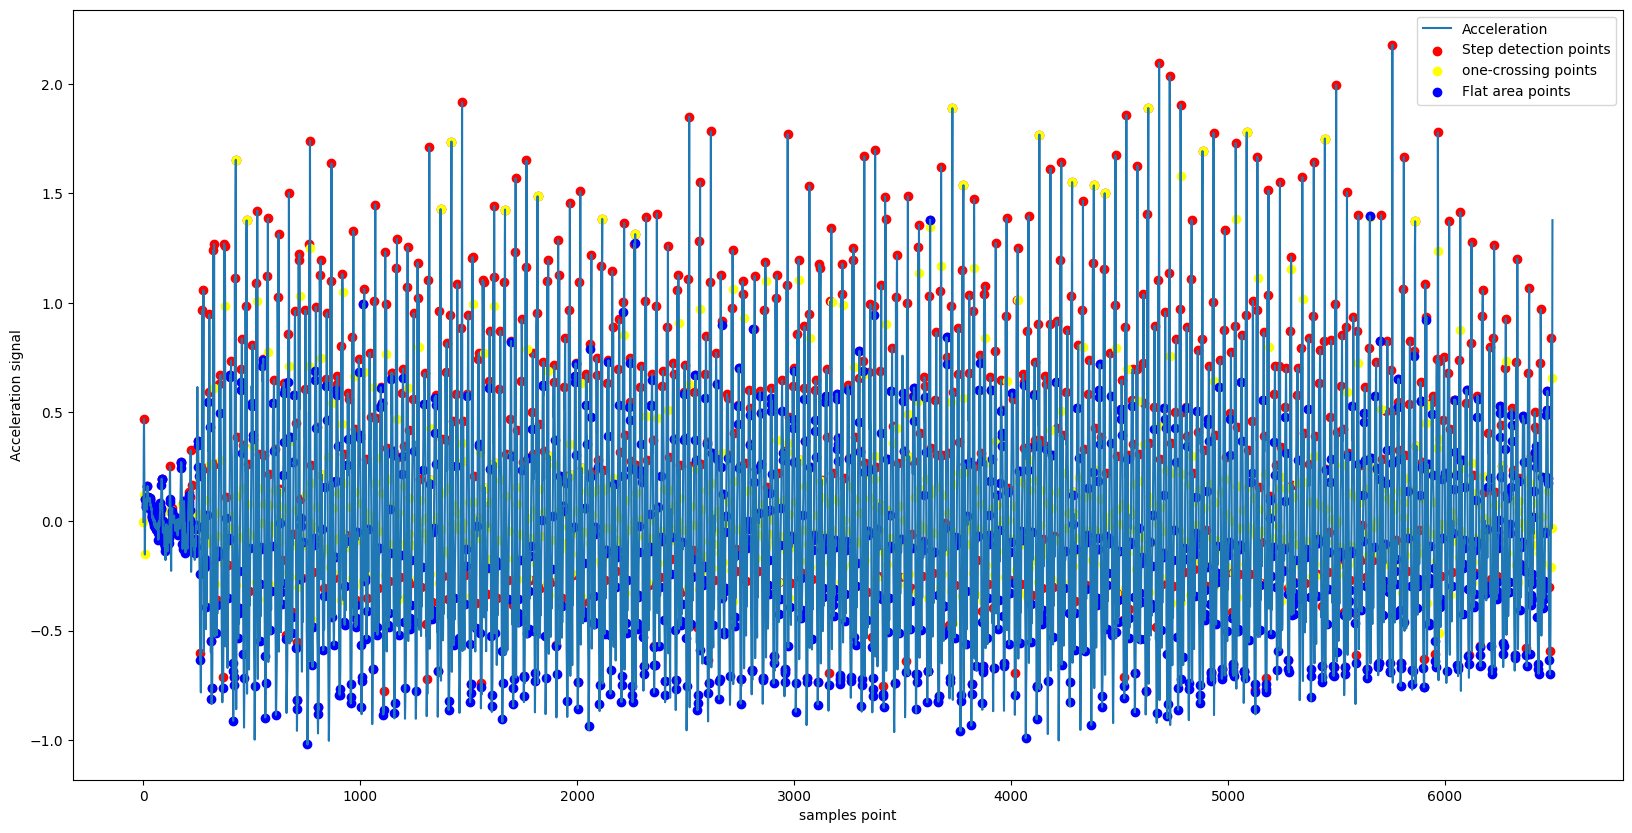

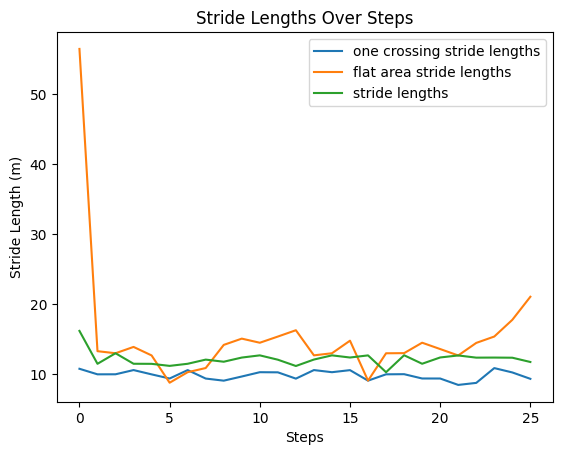

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def zero_crossing_detection(signal):
    return np.where(np.diff(np.sign(signal)))[0]

def flat_area_detection(signal, threshold):
    diff = np.abs(np.diff(signal))
    return np.where(diff <= threshold)[0]

def butter_low_pass_filter(signal, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# 读取CSV文件
data = pd.read_csv(r'/workspaces/codespaces-jupyter/data/wlk_7/sub_3.csv')

# 计算步数和步长
window_size_seconds = 5  # 窗口大小（秒）
sampling_frequency = 50  # 采样频率（Hz）
window_size_samples = int(window_size_seconds * sampling_frequency)  # 窗口大小（采样点数）
step_length_params = {
    'alpha': 0.3,  # 步幅参数 alpha
    'beta': 0.4,   # 步幅参数 beta
    'gamma': 0.3   # 步幅参数 gamma
}

step_count = 0
stride_lengths = []
step_indices = []
one_crossing_indices = []
flat_area_indices = []

# 计算加速度
data['acceleration'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

# 去除重力分量
cutoff_frequency = 0.25 # 截止频率（Hz）
filter_order = 4 # 滤波器阶数

gravity = butter_low_pass_filter(data['acceleration'], cutoff_frequency, sampling_frequency, filter_order)


data['acceleration'] = data['acceleration'] - gravity

for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]
    acceleration = window['acceleration']  # 假设加速度数据列名为 'acceleration'

    # 检测步幅
    peaks = acceleration[(acceleration.shift(1) < acceleration) & (acceleration.shift(-1) < acceleration)]
    stride_count = len(peaks)
    step_indices.extend(peaks.index.tolist())
    

    # 零交叉检测和平坦区域检测
    
    # 1交叉检测
    one_crossings = zero_crossing_detection(acceleration.values)
    one_crossing_indices.extend(one_crossings + i)
    
    flat_areas = flat_area_detection(acceleration.values, threshold=0.5)
    flat_area_indices.extend(flat_areas + i)
    

    # 计算步幅长度
    variance = acceleration.std()**2
    stride_length = step_length_params['alpha'] * stride_count + step_length_params['beta'] * variance + step_length_params['gamma']
    
    stride_lengths.append(stride_length)

    # 更新步数
    step_count += stride_count

# 计算速度
total_stride_length = sum(stride_lengths)  # 所有步幅长度之和（单位：公里）
duration = len(data) / sampling_frequency # 数据持续时间（单位：小时）
speed = (total_stride_length) / duration # 速度（单位：km/h）
print("步幅长度之和:", total_stride_length)
print("步数:", step_count)
print("速度:", speed)
one_crossing_indices = []
flat_area_indices = []

one_crossing_step_count = 0
flat_area_step_count = 0
one_crossing_stride_lengths = []
flat_area_stride_lengths = []
one_crossing_steps = []
flat_area_steps = []

for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]
    acceleration = window['acceleration']  # 假设加速度数据列名为 'acceleration'

    # 计算方差
    variance = np.var(acceleration)

    # 1交叉检测
    one_crossings =  zero_crossing_detection(acceleration.values)
    one_crossing_indices.extend(one_crossings + i)
    one_crossing_step_count += len(one_crossings)
    one_crossing_steps.append(len(one_crossings))
    
    

    # 平坦区域检测
    flat_areas = flat_area_detection(acceleration.values, threshold=0.05)
    flat_area_indices.extend(flat_areas + i)
    flat_area_step_count += len(flat_areas)
    flat_area_steps.append(len(flat_areas))
    

    # 计算1交叉和平坦区域的步幅长度
    one_crossing_stride_length = step_length_params['alpha'] * len(one_crossings) + step_length_params['beta'] * variance + step_length_params['gamma']
    flat_area_stride_length = step_length_params['alpha'] * len(flat_areas) + step_length_params['beta'] * variance + step_length_params['gamma']
    
    one_crossing_stride_lengths.append(one_crossing_stride_length)
    flat_area_stride_lengths.append(flat_area_stride_length)

# 计算1交叉和平坦区域的总步数
total_one_crossing_steps = sum(one_crossing_steps)  # 所有1交叉步数之和
total_flat_area_steps = sum(flat_area_steps)  # 所有平坦区域步数之和

print("1交叉总步数:", total_one_crossing_steps)
print("平坦区域总步数:", total_flat_area_steps)

# 计算1交叉和平坦区域的总步幅长度
total_one_crossing_stride_length = sum(one_crossing_stride_lengths)  # 所有1交叉步幅长度之和（单位：公里）
total_flat_area_stride_length = sum(flat_area_stride_lengths)  # 所有平坦区域步幅长度之和（单位：公里）

print("1交叉步幅长度之和:", total_one_crossing_stride_length)
print("平坦区域步幅长度之和:", total_flat_area_stride_length)
print("步幅长度:", total_stride_length/step_count)
print("1交叉步幅长度:", total_one_crossing_stride_length/total_one_crossing_steps)
print("平坦区域步幅长度:", total_flat_area_stride_length/total_flat_area_steps)
sampling_frequency = 50  # 将采样率传递给变量sampling_frequency
duration = len(data) / sampling_frequency  # 计算持续时间（单位：秒）
print("时间:",duration,  "s")
# 计算1交叉和平坦区域的速度
total_one_crossing_speed = total_one_crossing_stride_length / (duration )
total_flat_area_speed = total_flat_area_stride_length / (duration )

print("1交叉区域速度:", round(total_one_crossing_speed,2), " m/s")
print("平坦区域速度:", round(total_flat_area_speed,2), " m/s")
# 绘制信号图
plt.figure(figsize=(20, 10))
plt.plot(data.index, data['acceleration'], label='Acceleration')
plt.scatter(step_indices, data['acceleration'][step_indices], color='red', label='Step detection points')
plt.scatter(one_crossing_indices, data['acceleration'][one_crossing_indices], color='yellow', label='one-crossing points')
plt.scatter(flat_area_indices, data['acceleration'][flat_area_indices], color='blue', label='Flat area points')
plt.xlabel('samples point')
plt.ylabel('Acceleration signal')
plt.legend()
plt.show()
# 绘制one_crossing_stride_lengths、flat_area_stride_lengths和stride_lengths三个列表的折线图
plt.plot(one_crossing_stride_lengths, label='one crossing stride lengths')
plt.plot( flat_area_stride_lengths, label='flat area stride lengths')
plt.plot( stride_lengths, label='stride lengths')

# 添加标题、x轴标签和y轴标签
plt.title('Stride Lengths Over Steps')
plt.xlabel('Steps')
plt.ylabel('Stride Length (m)')

# 添加图例
plt.legend()

# 显示图形
plt.show()


步数： 424
步频： 4.2926730261822605 Hz
步幅： 0.6342088366920241


Text(0, 0.5, 'Acceleration')

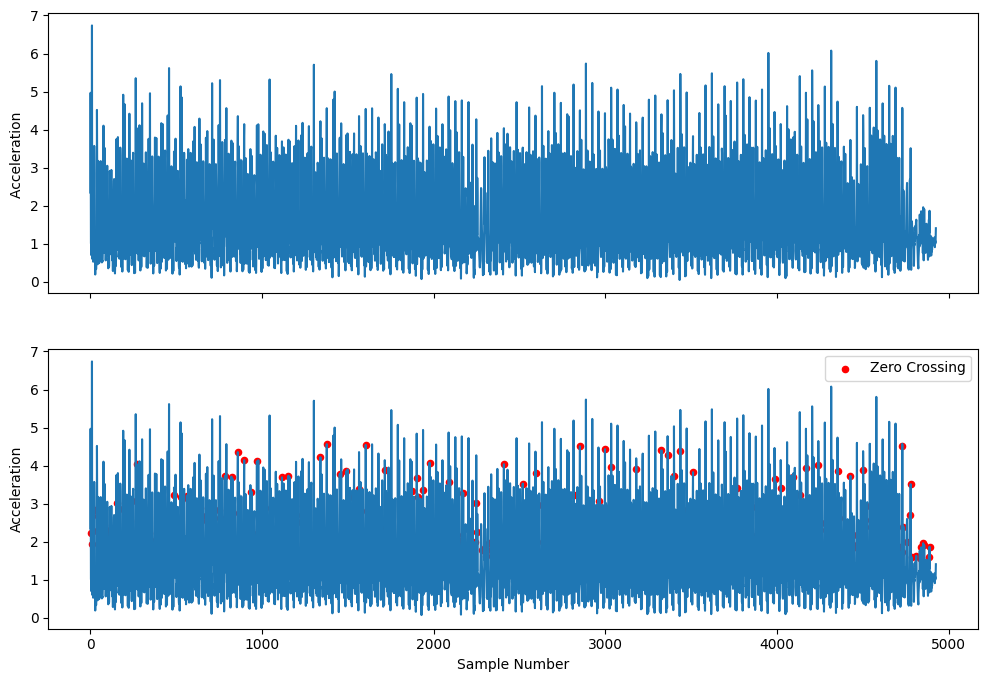

In [20]:
import csv
import matplotlib.pyplot as plt

# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/jog_9/sub_1.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1]))
        y_axis.append(float(row[2]))
        z_axis.append(float(row[3]))

# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]

fs = 50

# Zero Crossing Detection的阈值和初始状态
threshold = sum(magnitudes) / len(magnitudes)
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True

# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)

# 计算每个步幅的距离
step_length_params = {
    'alpha': 0.3,  # 步幅参数 alpha
    'beta': 0.4,   # 步幅参数 beta
    'gamma': 0.3   # 步幅参数 gamma
}

time_seconds = len(magnitudes)/ fs

# 计算步频（步数/秒）
step_frequency = len(stride_lengths) / time_seconds

# 计算每个步幅的频率和方差

variances=np.var(magnitudes)

alpha = 0.1
beta =0.1
gamma =0.1

stride_length = alpha*step_frequency + beta*variances+ gamma

print("步数：", num_steps)
print("步频：", step_frequency, "Hz")
print("步幅：", stride_length)



# 绘制加速度magnitude和Zero Crossing检测图
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
axs[0].plot(magnitudes)
axs[0].set_ylabel("Acceleration ")
axs[1].plot(magnitudes)
axs[1].scatter(crossing_points_x, crossing_points_y, s=20, c='r', marker='o', label='Zero Crossing')
axs[1].legend()
axs[1].set_xlabel("Sample Number")
axs[1].set_ylabel("Acceleration")


步数： 378
步频： 3.4191910030836206 Hz
tian_step_length 1.0912163034614322
Renaudin_tep_length 0.9308079085797207


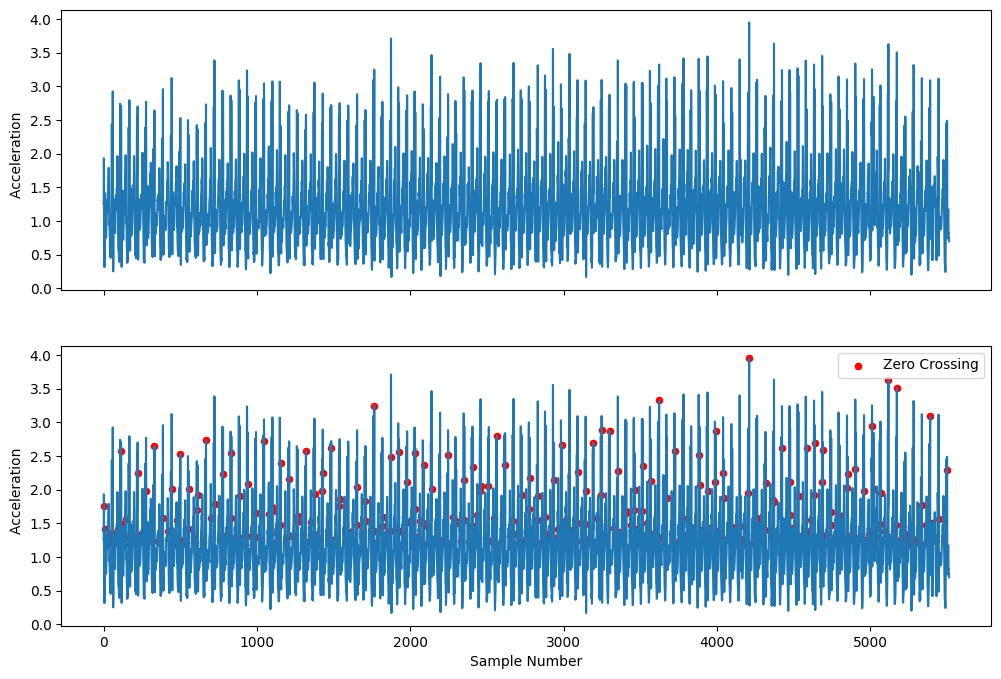

In [58]:
import csv
import matplotlib.pyplot as plt

# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/wlk_7/sub_1.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1]))
        y_axis.append(float(row[2]))
        z_axis.append(float(row[3]))
# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]
fs=50
# 计算Zero Crossing Detection的阈值和初始状态
threshold = sum(magnitudes) / len(magnitudes)
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True

# 绘制加速度magnitude和Zero Crossing检测图
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
axs[0].plot(magnitudes)
axs[0].set_ylabel("Acceleration  ")
axs[1].plot(magnitudes)
axs[1].scatter(crossing_points_x, crossing_points_y, s=20, c='r', marker='o', label='Zero Crossing')
axs[1].legend()
axs[1].set_xlabel("Sample Number")
axs[1].set_ylabel("Acceleration  ")

print("步数：", num_steps)
# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)

# 计算时间（秒）
time_seconds = len(magnitudes)/ fs

# 计算步频（步数/秒）
step_frequency = len(stride_lengths) / time_seconds

print("步频：", step_frequency, "Hz")
#tian
tian_step_length=0.3139 *np.sqrt(step_frequency)*1.88
print("tian_step_length",tian_step_length)
Renaudin_tep_length=1.88*(0.1*step_frequency+0.1)+0.1
print("Renaudin_tep_length",Renaudin_tep_length)

前5.12秒的步频： 3.90625 Hz


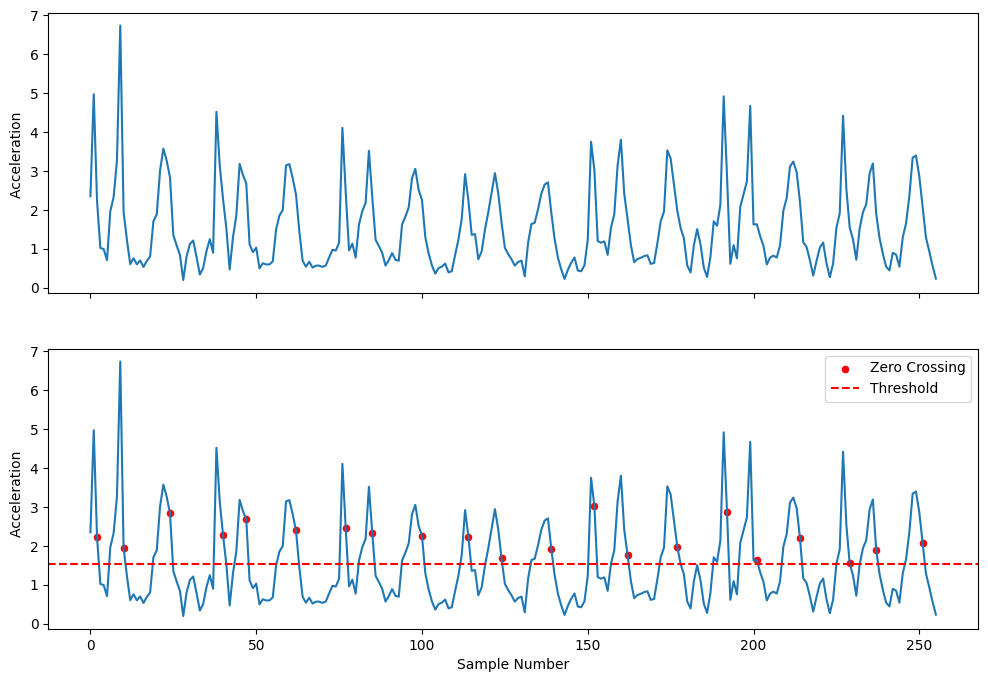

In [36]:
import csv
import matplotlib.pyplot as plt

# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/jog_9/sub_3.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行 

    fs = 50 # 采样率
    t_start, t_end = 0, 5.12 # 设定起始时间和结束时间
    n_start, n_end = int(t_start * fs), int(t_end * fs) # 转换为对应索引
    x_axis, y_axis, z_axis = [], [], []
    for i, row in enumerate(csv_reader):
        if n_start <= i < n_end:
            x_axis.append(float(row[1]))
            y_axis.append(float(row[2]))
            z_axis.append(float(row[3]))

# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]

# 计算Zero Crossing Detection的阈值和初始状态
threshold = sum(magnitudes) / len(magnitudes)
#threshold = np.median(magnitudes) 
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True

# 绘制加速度magnitude和Zero Crossing检测图，包括阈值
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
axs[0].plot(magnitudes)
axs[0].set_ylabel("Acceleration ")



axs[1].plot(magnitudes)
axs[1].scatter(crossing_points_x, crossing_points_y, s=20, c='r', marker='o', label='Zero Crossing')
axs[1].axhline(y=threshold, color="r", linestyle="--", label="Threshold")
axs[1].legend()
axs[1].set_xlabel("Sample Number")
axs[1].set_ylabel("Acceleration  ")


# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)

# 计算时间（秒）
time_seconds = (n_end - n_start) / fs

# 计算步频（步数/秒）
step_frequency = len(stride_lengths) / time_seconds

print("前5.12秒的步频：", step_frequency, "Hz")

1.4009553855979069
time_seconds 129.92
step_count 268
step_frequency 2.062807881773399
stride_length 0.4717317208808025
速度: 0.9730919119154486


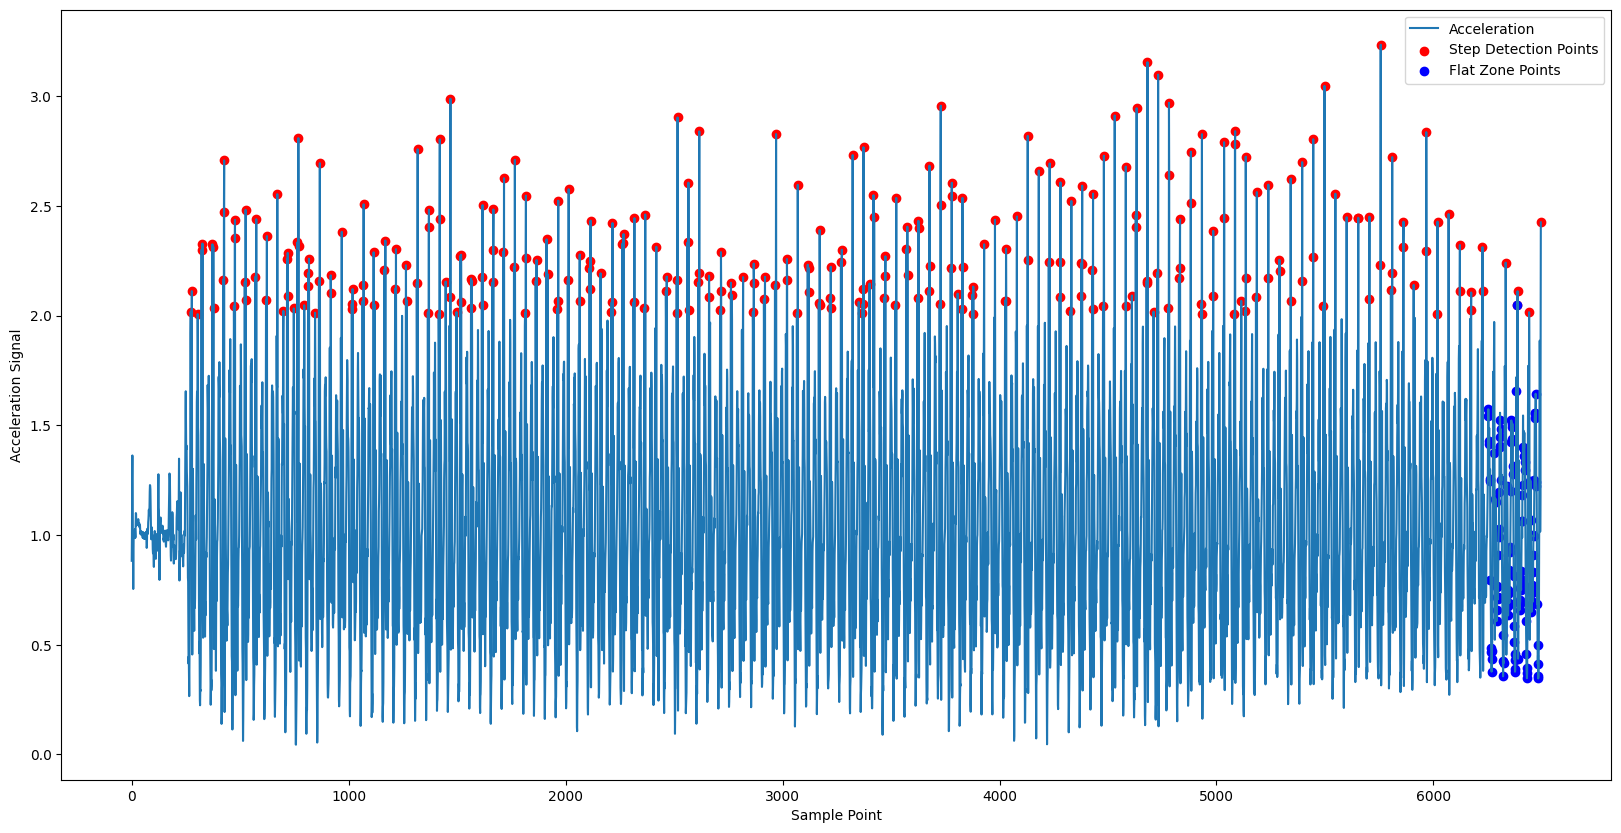

In [59]:
import numpy as np
import pandas as pd

def flat_zone_detection(signal, threshold):
    """
    Flat Zone Detection算法用于检测步数。
    
    :param signal: list，要处理的信号。
    :param threshold: float，设定的平坦区域阈值。
    :return:
        flat_zone_indices: ndarray，signal中的平坦区域所在的位置下标。
    """
    diff = np.abs(np.diff(signal))
    flat_zone_indices = np.where(diff <= threshold)[0]
    return flat_zone_indices

def peak_detection(signal, threshold):
    """
    Peak Detection算法用于检测步数。
    
    :param signal: list，要处理的信号。
    :param threshold: float，峰值检测的阈值。
    :return:
        peaks: ndarray，signal中所有的峰值所在的位置下标。
    """
    peaks = np.where(signal >= threshold)[0]
    return peaks

# 读取CSV文件
data = pd.read_csv(r'/workspaces/codespaces-jupyter/data/wlk_7/sub_3.csv')

# 计算步数和步长
window_size_seconds = 5  # 窗口大小（秒）
sampling_frequency = 50  # 采样频率（Hz）
window_size_samples = int(window_size_seconds * sampling_frequency)  # 窗口大小（采样点数）
step_length_params = {
    'alpha': 0.1,  # 步幅参数 alpha
    'beta': 0.1,   # 步幅参数 beta
    'gamma': 0.1   # 步幅参数 gamma
}

step_count = 0
stride_lengths = []
step_indices = []

# 计算加速度信号
data['acceleration'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
acceleration75th = np.percentile(data['acceleration'], 75)
print(acceleration75th)
for i in range(0, len(data), window_size_samples):
    window = data.iloc[i:i+window_size_samples]

    acceleration = window['acceleration']
    variance = acceleration.std() ** 2
    
    

    flat_zone_indices = flat_zone_detection(acceleration.values, threshold=0.1) + i
    peaks = peak_detection(acceleration.values, threshold=2) + i

    # 根据峰值数量和平坦区域来确定步数
    if len(peaks) >= 2 and flat_zone_indices.size > 0:
        step_indices.extend(peaks.tolist())
        stride_count = len(peaks) - 1
        
        step_count += stride_count

# 计算行走速度
# 计算时间（秒）
time_seconds =len( data['acceleration'])/ fs
variance =np.var(data['acceleration'] ** 2)
# 计算步频（步数/秒）
step_frequency =step_count / time_seconds
stride_length = step_length_params['alpha'] * step_frequency + step_length_params['beta'] * variance + step_length_params['gamma']

speed = (stride_length*step_count) / duration # 速度（单位：km/h）
print("time_seconds", time_seconds)
print("step_count", step_count)
print("step_frequency", step_frequency)
print("stride_length", stride_length)
print("速度:", speed)

# 绘制加速度信号图、步伐点和平坦区域点
plt.figure(figsize=(20, 10))
plt.plot(data.index, data['acceleration'], label='Acceleration')
plt.scatter(step_indices, data['acceleration'][step_indices], color='red', label='Step Detection Points')
plt.scatter(flat_zone_indices, data['acceleration'][flat_zone_indices], color='blue', label='Flat Zone Points')
plt.xlabel('Sample Point')
plt.ylabel('Acceleration Signal')
plt.legend()
plt.show()


 

In [6]:
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/wlk_7/sub_3.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1]))
        y_axis.append(float(row[2]))
        z_axis.append(float(row[3]))
# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]
fs=50
# 计算Zero Crossing Detection的阈值和初始状态
#threshold = sum(magnitudes) / len(magnitudes)
threshold=2.22
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True


print("步数：", num_steps)
# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)


# 计算每个步幅的aavg_abs和av并统计总体指标
total_aavg_abs_list = []
total_av_list = []
for i in range(len(stride_lengths)):
    start_idx = crossing_points_x[i]
    end_idx = crossing_points_x[i+1] if i+1<len(stride_lengths) else len(magnitudes)-1
    vertical_accelerations = np.diff(y_axis[start_idx:end_idx])
    if len(vertical_accelerations)>0:
        aavg_abs = np.mean(np.abs(vertical_accelerations))
        av = np.max(vertical_accelerations) - np.min(vertical_accelerations)
        total_aavg_abs_list.append(aavg_abs)
        total_av_list.append(av)

# 计算平均aavg_abs和av值
avg_aavg_abs = np.mean(total_aavg_abs_list)
avg_av = np.mean(total_av_list)

# 计算时间（秒）
time_seconds = len(magnitudes) / fs

# 每一步需要的时间
step_time = time_seconds / num_steps
print("每步的时间：", step_time)

# 计算步频（步数/秒）
step_frequency = num_steps / time_seconds
print("步频：", step_frequency, "Hz")
print("avg_aavg_abs",avg_aavg_abs)
print("avg_av",avg_av)
# 计算时间（秒）
time_seconds = len(magnitudes)/ fs
absolute_accelerations = [abs(a) for a in magnitudes]
aavg = sum(absolute_accelerations) / len(absolute_accelerations)
print(aavg)
# 计算步频（步数/秒）
step_frequency = len(stride_lengths) / time_seconds
variancer=np.var(magnitudes)

print("步频：", step_frequency, "Hz")
#tian0.2975，0.3139
tian_step_length=0.33 *np.sqrt(step_frequency)*1.61
print("tian_step_length",tian_step_length)
tian_speed=(tian_step_length*num_steps)/time_seconds
print("tian_speed",tian_speed)
Renaudin_tep_length=1.61*(0.17*step_frequency)+0.71
print("Renaudin_tep_length",Renaudin_tep_length)
Renaudin_speed=(Renaudin_tep_length*num_steps)/time_seconds
print("Renaudin_speed",Renaudin_speed)
Alvarez_tep_length=0.311*step_frequency+0.23
print("Alvarez_tep_length",Alvarez_tep_length)
Alvarez_speed=(Alvarez_tep_length*num_steps)/time_seconds
print("Alvarez_speed",Alvarez_speed)
sh_step_length= 0.24409657501163742*step_frequency+0.077*variancer+0.204
print("sh_step_length",sh_step_length)
sh_speed=(sh_step_length*num_steps)/time_seconds
print("sh_speed",sh_speed)
Guo_step_length=-5.5*math.pow(aavg,1/3)+6.6
print("Guo_step_length",Guo_step_length)
Guo_speed=(Guo_step_length*num_steps)/time_seconds
print("Guo_speed",Guo_speed)
Weinberg_step_length=0.56*math.pow(avg_av,1/4)
print("Weinberg_step_length",Weinberg_step_length)
Weinberg_speed=(Weinberg_step_length*num_steps)/time_seconds
print("Weinberg_speed",Weinberg_speed)
Mikov_step_length=math.pow(avg_av,1/4)*0.87/step_frequency
print("Mikov_step_length",Mikov_step_length)
Mikov_speed=(Mikov_step_length*num_steps)/time_seconds
print("Mikov_speed",Mikov_speed)
Bylemanstep_length=0.1*math.pow(avg_aavg_abs*np.sqrt(308813.3220269576*np.sqrt(step_frequency/avg_av)),1/2.7)
print("Bylemanstep_length",Bylemanstep_length)
Byleman_speed=(Bylemanstep_length*num_steps)/time_seconds
print("Byleman_speed",Byleman_speed)
frms = math.sqrt(sum([magnitude**2 for magnitude in magnitudes]) / len(magnitudes))
print("frms:", frms)

Metsf = 1.8 * frms*9.8  - 15
print("Metsf:", Metsf)

步数： 122
每步的时间： 1.0649180327868852
步频： 0.9390394088669952 Hz
avg_aavg_abs 0.2618740237456984
avg_av 2.0867335619834715
1.0529109014365454
步频： 0.9313423645320198 Hz
tian_step_length 0.5127368076742351
tian_speed 0.48148006878276395
Renaudin_tep_length 0.9649084051724137
Renaudin_speed 0.9060870184038985
Alvarez_tep_length 0.5196474753694582
Alvarez_speed 0.4879694580901625
sh_step_length 0.4517338971381474
sh_speed 0.4241959317337899
Guo_step_length 1.0046589426968469
Guo_speed 0.9434143396629874
Weinberg_step_length 0.6730615437385424
Weinberg_speed 0.632031314163348
Mikov_step_length 1.1227334048610527
Mikov_speed 1.0542909128159517
Bylemanstep_length 0.5870140924778612
Byleman_speed 0.5512293663970065
frms: 1.171968379757524
Metsf: 5.673522218922724


In [11]:
import numpy as np

# Generate data (replace with your actual data)
data = [
    {'step_length': 0.99, 'step_frequency': 2.5073746312684366, 'variance': 1.6977663927778883},
    # Add more data points
]

# Create matrices for the RLS method
X = np.array([[d['step_frequency'], d['variance'], 1] for d in data])
y = np.array([d['step_length'] for d in data])

# Initialize RLS filter
n, m = X.shape
P = np.identity(m) * 1e6  # Large initial covariance matrix
theta = np.zeros(m)       # Initial parameter estimates

# RLS algorithm
for i in range(n):
    x = X[i, :].reshape(-1, 1)
    y_obs = y[i]

    # Update the parameter estimates
    K = P @ x / (1 + x.T @ P @ x)
    P = P - K @ x.T @ P
    theta = theta + K.flatten() * (y_obs - x.T @ theta)

alpha, beta, gamma = theta
print(f'alpha: {alpha}, beta: {beta}, gamma: {gamma}')
import numpy as np

# Generate data (replace with your actual data)
data = [
    {'step_length': 0.99, 'F': 2.5073746312684366},
    {'step_length': 1.055192994516906, 'F': 3.1662269129287597  },
]

# Create matrices for the OLS method
X = np.array([[d['F'], 1] for d in data])
y = np.array([d['step_length'] for d in data])

# Calculate the parameters using OLS
theta = np.linalg.inv(X.T @ X) @ X.T @ y

K1, K2 = theta
print(f'K1: {K1}, K2: {K2}')

import numpy as np

# 生成数据 (替换为您的实际数据), 这里提供了两个数据点进行演示
data = [
    {'step_length':  0.99, 'av': 1.5445517155802917},
    {'step_length': 1.055192994516906, 'av': 1.5507573406770538}
]

# 设置O(LS)所需的矩阵
X = np.array([[d['av']**(1/3), 1] for d in data])
y = np.array([d['step_length'] for d in data])

# 利用O(LS)算法求解参数
theta = np.linalg.inv(X.T @ X) @ X.T @ y

K1, K2 = theta
print(f'K1: {K1}, K2: {K2}')

import math
from scipy.optimize import fsolve

avg_aavg_abs = 0.4045904010875844
avg_av = 2.5120873469387757
step_frequency = 1.535219747140277

# 定义方程
def equation(K):
    return 0.71 - 0.1 * math.pow(avg_aavg_abs * math.sqrt(K * math.sqrt(step_frequency / avg_av)), 1/2.7)

# 使用 fsolve 函数解方程
K = fsolve(equation, 1)  # 从初始猜测值 1 开始求解

print(f'K: {K[0]}')

import math

avg_av = 2.5120873469387757
step_frequency = 1.535219747140277

K = 0.71 * step_frequency / math.pow(avg_av, 1/4)

print(f'K: {K}')




alpha: 0.24409657501163742, beta: 0.16528003293919333, gamma: 0.09735145756346482
K1: -0.12372005786925477, K2: 1.3002125344804307
K1: -5.5556382205329005, K2: 6.611943751794715
K: 308813.3220269576
K: 0.8658052455506179


1.5445517155802917
阈值： 3.225204304407068
步数： 36
frequency: 1.7699115044247788
varance 1.6977663927778883
0.9938888888888889


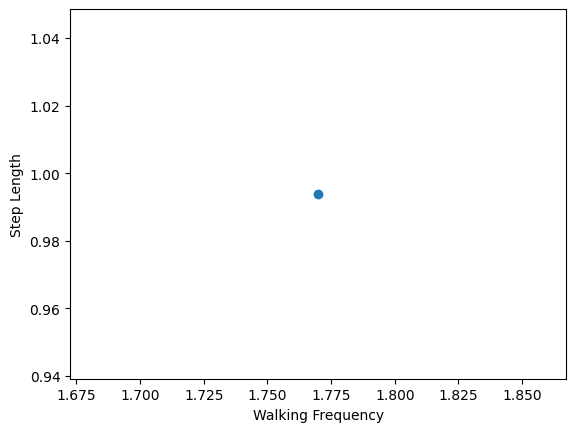

In [8]:
import csv
import numpy as np

# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/my_data/running_3_36step.csv', 'r', encoding='ISO-8859-1') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1])/9.8)
        y_axis.append(float(row[2])/9.8)
        z_axis.append(float(row[3])/9.8)

# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]

fs = 50

def count_steps(threshold):
    is_above_threshold = False
    num_steps = 0
    crossing_points_x, crossing_points_y = [], []
    
    # 遍历每个数据点并检测步数
    for i in range(1, len(magnitudes)):
        if is_above_threshold:
            if magnitudes[i] < threshold:
                num_steps += 1
                is_above_threshold = False
        else:
            if magnitudes[i] > threshold:
                is_above_threshold = True
    return num_steps

# 使用二分查找法寻找合适的阈值
target_steps =36
lower_threshold = min(magnitudes)
upper_threshold = max(magnitudes)
while upper_threshold - lower_threshold > 1e-6:
    mid_threshold = (lower_threshold + upper_threshold) / 2
    steps = count_steps(mid_threshold)
    if steps > target_steps:
        lower_threshold = mid_threshold
    else:
        upper_threshold = mid_threshold

threshold = (lower_threshold + upper_threshold) / 2
num_steps = count_steps(threshold)
absolute_accelerations = [abs(a) for a in magnitudes]
aavg = sum(absolute_accelerations) / len(absolute_accelerations)
print(aavg)
print("阈值：", threshold)
print("步数：", num_steps)
time=len(magnitudes)/50
print("frequency:",num_steps/time)
varance=np.var(magnitudes)
print("varance",varance)
step_length=35.78/36
print(step_length)
# Calculate walking frequency and step length
frequency = num_steps / time
step_length = 35.78 / 36

# Store the values in lists
frequencies = [frequency]
step_lengths = [step_length]

# Plot the walk data for learning
plt.scatter(frequencies, step_lengths)
plt.xlabel('Walking Frequency')
plt.ylabel('Step Length')
plt.show()





In [5]:
import csv
import matplotlib.pyplot as plt

# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/wlk_7/sub_1.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1]))
        y_axis.append(float(row[2]))
        z_axis.append(float(row[3]))
# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]
fs=50
# 计算Zero Crossing Detection的阈值和初始状态
threshold = sum(magnitudes) / len(magnitudes)
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True



print("步数：", num_steps)
# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)

# 计算时间（秒）
time_seconds = len(magnitudes)/ fs
#每一步需要的时间
ever_step_time=time_seconds/num_steps
#每一步的采样点数
time_point=ever_step_time*50
# 计算步频（步数/秒）
step_frequency = len(stride_lengths) / time_seconds

print("步频：", step_frequency, "Hz")

print("每步的时间：", ever_step_time)
print("每步的采样点数：", time_point)


步数： 378
步频： 3.4191910030836206 Hz
每步的时间： 0.2916931216931217
每步的采样点数： 14.584656084656086


In [17]:
import csv
import numpy as np

# 读取csv文件并将数据保存到accelerations列表中
with open('/workspaces/codespaces-jupyter/data/my_data/walking_3_50step.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # 跳过标题行
    x_axis, y_axis, z_axis = [], [], []
    for row in csv_reader:
        x_axis.append(float(row[1])/9.8)
        y_axis.append(float(row[2])/9.8)
        z_axis.append(float(row[3])/9.8)

# 计算加速度的欧氏长度（magnitude）
magnitudes = [sum([a**2 for a in accel])**(1/2) for accel in zip(x_axis, y_axis, z_axis)]

fs = 50

# 计算Zero Crossing Detection的阈值和初始状态
threshold = 2.22
is_above_threshold = False
num_steps = 0
crossing_points_x, crossing_points_y = [], []

# 遍历每个数据点并检测步数
for i in range(1, len(magnitudes)):
    if is_above_threshold:
        if magnitudes[i] < threshold:
            num_steps += 1
            is_above_threshold = False
            
            # 绘制Zero Crossing的位置图
            crossing_points_x.append(i - 1)
            crossing_points_y.append(magnitudes[i-1])
    else:
        if magnitudes[i] > threshold:
            is_above_threshold = True

print("步数：", num_steps)

# 计算每个步幅的样本数
stride_lengths = []
for i in range(1, len(crossing_points_x)):
    stride_length = crossing_points_x[i] - crossing_points_x[i-1]
    stride_lengths.append(stride_length)

# 计算每个步幅的aavg_abs和av并统计总体指标
total_aavg_abs_list = []
total_av_list = []
for i in range(len(stride_lengths)):
    start_idx = crossing_points_x[i]
    end_idx = crossing_points_x[i+1] if i+1<len(stride_lengths) else len(magnitudes)-1
    vertical_accelerations = np.diff(y_axis[start_idx:end_idx])
    if len(vertical_accelerations)>0:
        aavg_abs = np.mean(np.abs(vertical_accelerations))
        av = np.max(vertical_accelerations) - np.min(vertical_accelerations)
        total_aavg_abs_list.append(aavg_abs)
        total_av_list.append(av)

# 计算平均aavg_abs和av值
avg_aavg_abs = np.mean(total_aavg_abs_list)
avg_av = np.mean(total_av_list)

# 计算时间（秒）
time_seconds = len(magnitudes) / fs

# 每一步需要的时间
step_time = time_seconds / num_steps
print("每步的时间：", step_time)

# 计算步频（步数/秒）
step_frequency = num_steps / time_seconds
print("步频：", step_frequency, "Hz")
print("avg_aavg_abs",avg_aavg_abs)
print("avg_av",avg_av)
print("speed:",35.78/time_seconds)
frms = math.sqrt(sum([magnitude**2 for magnitude in magnitudes]) / len(magnitudes))
print("frms:", frms)

Metsf = 1.8 * frms*9.8  - 15
print("Metsf:", Metsf)
print("time",time_seconds)

步数： 48
每步的时间： 0.6920833333333333
步频： 1.4449127031908489 Hz
avg_aavg_abs 0.4103268077167756
avg_av 2.586809161962657
speed: 1.0770620108368454
frms: 1.3442077423974883
Metsf: 8.711824575891697
time 33.22
